In [1]:
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from matplotlib.backends.backend_pdf import PdfPages

import seaborn as sns


## Load the heatwaves data

### Drop duplicate rows

In [2]:
df_heatwave = pd.read_csv('results/heatwave_urban.csv')
df_heatwave = df_heatwave.drop_duplicates()
df_heatwave.to_csv('results/heatwave_urban.csv', index=False)

### Find the overlap heatwaves between models

In [3]:
# Ensure the 'exceedance_times' column is in datetime format
df_heatwave['exceedance_times'] = pd.to_datetime(df_heatwave['exceedance_times'], format='mixed')

# Group by city and exceedance time, and aggregate the list of models with their versions
df_coincidences = df_heatwave.groupby(['city', 'exceedance_times']) \
    .agg(Model_Count=('model', 'count'), Models=('model', lambda x: ', '.join(x))).reset_index()

# Apply filter: for PortoAlegre, Model_Count > 3, for other cities, Model_Count > 4
df_result = df_coincidences[
    ((df_coincidences['city'] == 'PortoAlegre') & (df_coincidences['Model_Count'] > 5)) |
    ((df_coincidences['city'] != 'PortoAlegre') & (df_coincidences['Model_Count'] > 6))
].reset_index(drop=True)

print(df_result)

df_result.to_csv("results/heatwave_coincidences.csv", index=False)

           city exceedance_times  Model_Count  \
0   BuenosAires       2018-11-21            7   
1   BuenosAires       2019-01-28            7   
2   BuenosAires       2019-01-29            7   
3   BuenosAires       2019-02-19            7   
4   BuenosAires       2019-02-20            7   
5   BuenosAires       2019-12-09            7   
6   BuenosAires       2019-12-10            7   
7   BuenosAires       2020-01-19            7   
8   BuenosAires       2020-01-20            7   
9   BuenosAires       2020-01-24            7   
10  BuenosAires       2020-01-25            7   
11  BuenosAires       2020-02-02            7   
12  BuenosAires       2020-02-03            7   
13  BuenosAires       2020-02-04            7   
14  BuenosAires       2020-02-16            7   
15  BuenosAires       2020-12-10            7   
16  BuenosAires       2020-12-18            7   
17  BuenosAires       2021-01-23            7   
18  BuenosAires       2021-01-24            7   
19  BuenosAires     

## Plot the heatwaves

In [24]:
def plot_heatwaves(csv_file, overlap_csv, output_pdf):    
    """
    Reads a CSV file with heatwave data and plots it as a horizontal bar chart.
    Ensures color consistency across cities and highlights overlap periods from an external CSV.
    """
    # Read the main heatwave data
    df = pd.read_csv(csv_file)
    
    # Read the overlap data
    df_overlap = pd.read_csv(overlap_csv)
    
    # Convert date columns to datetime and ensure proper alignment
    df['exceedance_times'] = pd.to_datetime(df['exceedance_times'], errors='coerce')
    df['date'] = df['exceedance_times'].dt.floor("D")
    df_overlap['exceedance_times'] = pd.to_datetime(df_overlap['exceedance_times'], errors='coerce')
    df_overlap['date'] = df_overlap['exceedance_times'].dt.floor("D")

    # Drop NaN dates
    df = df.dropna(subset=['date'])
    
    # Fill NaN in 'version' with a placeholder value
    df['version'] = df['version'].fillna('No Version')
    
    # Expand overlap models to match df['model']
    df_overlap_expanded = df_overlap.assign(Models=df_overlap['Models'].str.split(', ')).explode('Models')

    # Get unique model-version pairs
    unique_models = df[['model', 'version']].drop_duplicates()
    
    # Sort models: OBS first, then alphabetically
    sorted_models = sorted(unique_models.values, key=lambda x: (x[0] != 'OBS', x[0]))

    model_colors = {
        "USP": "#1f77b4", 
        "NCAR": "#2ca02c",  
        "UCAN": "#ff7f0e",
        "ICTP": "#003366",
        "OBS": "#000000"   
    }
    
    # Define date range for x-axis
    date_range = pd.date_range("2017-12-01", "2022-01-30", freq='2MS')

    # Create a PDF file to save all plots
    with PdfPages(output_pdf) as pdf:
        for city in df['city'].unique():
            city_df = df[df['city'] == city]
            plt.figure(figsize=(8, 4))  # Adjusted figure size (smaller)
            ax = plt.gca()

            # Get overlap periods for this city (where 3+ models coincide)
            city_overlap = df_overlap_expanded[(df_overlap_expanded['city'] == city) & (df_overlap_expanded['Model_Count'] >= 3)]
            
            # Highlight overlap regions
            for _, row in city_overlap.iterrows():
                ax.axvspan(row['date'], row['date'] + pd.Timedelta(days=1), 
                           color='gray', alpha=0.025)

            # Iterate through models (sorted)
            for model, version in sorted_models:
                model_df = city_df[(city_df['model'] == model) & (city_df['version'] == version)]
                
                if model_df.empty:
                    continue
                
                label = f"{model}" if version == 'No Version' else f"{model} ({version})"
                color = model_colors[model]
                for _, row in model_df.iterrows():
                    plt.barh(label, 1, 
                             left=pd.to_datetime(row['date']), 
                             color=color)
            
            # Customize the plot
            plt.xlabel("Date")
            plt.ylabel("Models (Version)")
            plt.title(f"Heatwaves in {city}")
            plt.xticks(pd.to_datetime(date_range), rotation=45, fontsize=8)
            plt.yticks(fontsize=8)  # Adjust y-axis label size
            plt.grid(True, axis='x', linestyle='--', alpha=0.7)

            # Save current figure to PDF with adjusted layout
            pdf.savefig(bbox_inches='tight')  
            #plt.close()

    print(f"PDF saved successfully: {output_pdf}")


PDF saved successfully: results/heatwave.pdf


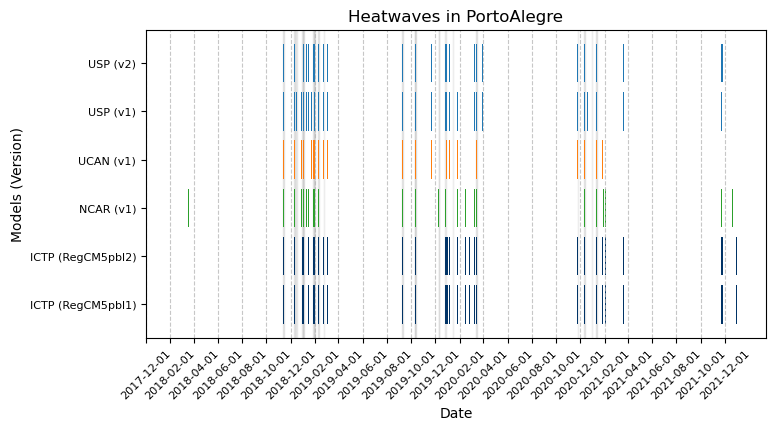

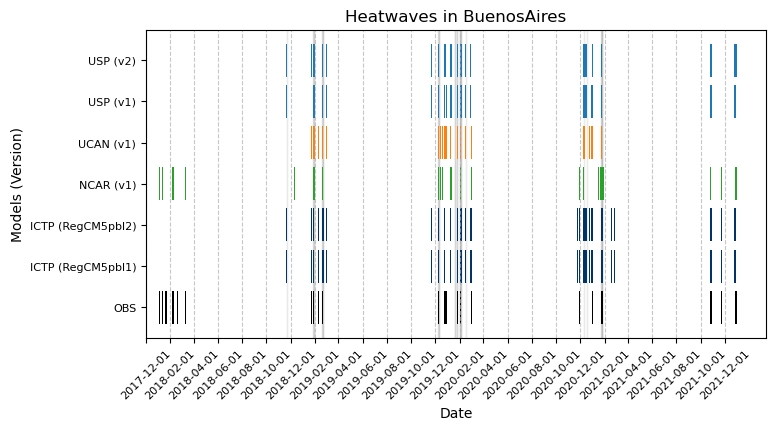

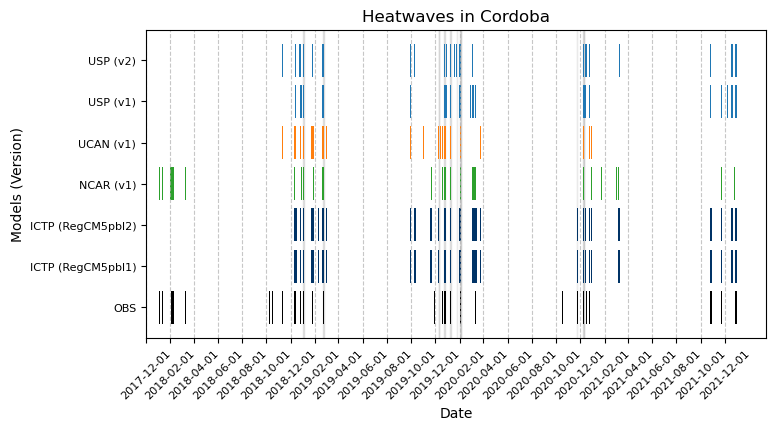

In [25]:
plot_heatwaves("results/heatwave_urban.csv", "results/heatwave_coincidences.csv",output_pdf="results/heatwave.pdf")

In [6]:
import pandas as pd

def analyze_heatwaves(input_csv, output_csv):
    # Load data
    df = pd.read_csv(input_csv)
    df['version'] = df['version'].fillna('No Version')    # Ensure the date column is datetime
    df['exceedance_times'] = pd.to_datetime(df['exceedance_times'], format='mixed')

    # Group by city, model, version
    results = []

    for (city, model, version), group in df.groupby(['city', 'model', 'version']):
        group = group.sort_values(by='exceedance_times')

        # Calculate gaps between consecutive days
        group['gap'] = group['exceedance_times'].diff().dt.days.fillna(1)

        # Count events and length of heatwaves
        event_count = 0
        current_streak = 0
        streak_lengths = []

        for gap in group['gap']:
            if gap == 1:
                current_streak += 1
            else:
                if current_streak > 0:
                    streak_lengths.append(current_streak)
                    event_count += 1
                current_streak = 1  # Start a new streak

        # If the last streak ends at the end of the group
        if current_streak > 0:
            streak_lengths.append(current_streak)
            event_count += 1

        # Calculate statistics
        total_days = sum(streak_lengths)
        average_streak_length = sum(streak_lengths) / len(streak_lengths) if streak_lengths else 0

        # Append results
        results.append({
            'city': city,
            'model': model,
            'version': version,
            'total_days': total_days,
            'event_count': event_count,
            'average_streak_length': average_streak_length
        })

    # Create result DataFrame and save to CSV
    result_df = pd.DataFrame(results)
    result_df.to_csv(output_csv, index=False)


In [7]:
analyze_heatwaves(f"results/heatwave_urban.csv", f"results/heatwave_urban_number.csv")

In [8]:
df_heatwave = pd.read_csv('results/heatwave_rural.csv')
df_heatwave = df_heatwave.drop_duplicates()
df_heatwave.to_csv('results/heatwave_rural.csv', index=False)
analyze_heatwaves(f"results/heatwave_rural.csv", f"results/heatwave_rural_number.csv")

In [9]:
def add_resolution_days(df):
    conditions = [
        (df['model'] == 'UCAN'),
        (df['model'] == 'NCAR'),
        (df['model'] == 'USP'),
        (df['model'] == 'ICTP') & (df['version'] == 'RegCM5pbl1'),
        (df['model'] == 'ICTP') & (df['version'] == 'RegCM5pbl2'),
        (df['model'] == 'OBS')
    ]
    values = [1096, 1460, 1309, 1308, 1291, 1460]

    df['resolution_days'] = 0  
    for condition, value in zip(conditions, values):
        df.loc[condition, 'resolution_days'] = value

    return df

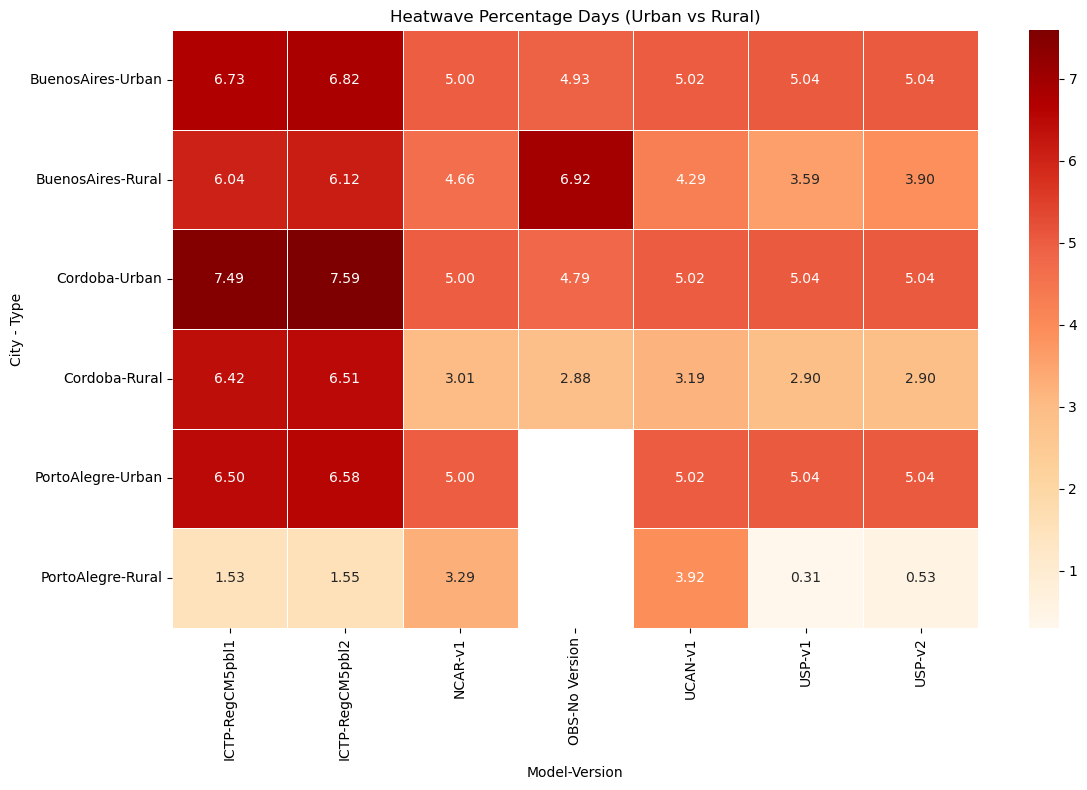

In [18]:
# Load urban and rural data
urban_df = pd.read_csv('results/heatwave_urban_number.csv')
rural_df = pd.read_csv('results/heatwave_rural_number.csv')

# Add resolution days to both datasets
urban_df = add_resolution_days(urban_df)
rural_df = add_resolution_days(rural_df)

# Add a column to distinguish between urban and rural data
urban_df['type'] = 'Urban'
rural_df['type'] = 'Rural'

# Concatenate both datasets into one combined dataframe
combined_df = pd.concat([urban_df, rural_df])

# Calculate the percentage of heatwave days
combined_df['percentage_days'] = combined_df['total_days'] / combined_df['resolution_days'] * 100

# Create a new column combining model and version
combined_df['model_version'] = combined_df['model'] + '-' + combined_df['version'].fillna('No Version')

# Pivot the data to make it suitable for a heatmap
pivot_df = combined_df.pivot_table(
    index=['city', 'type'],  # Rows will be city and type (urban/rural)
    columns='model_version',  # Columns will be the model-version combination
    values='percentage_days'  # Values will be the percentage of heatwave days
)

# Reorder rows so urban and rural are next to each other
pivot_df = pivot_df.reindex(
    [(city, t) for city in combined_df['city'].unique() for t in ['Urban', 'Rural']]
)

# Plot the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(pivot_df, annot=True, fmt=".2f", cmap='OrRd', linewidths=0.5)
plt.title('Heatwave Percentage Days (Urban vs Rural)')
plt.xlabel('Model-Version')
plt.ylabel('City - Type')
plt.tight_layout()

# Guardar primero
plt.savefig("results/heatwave_days.pdf", format='pdf')
plt.show()  


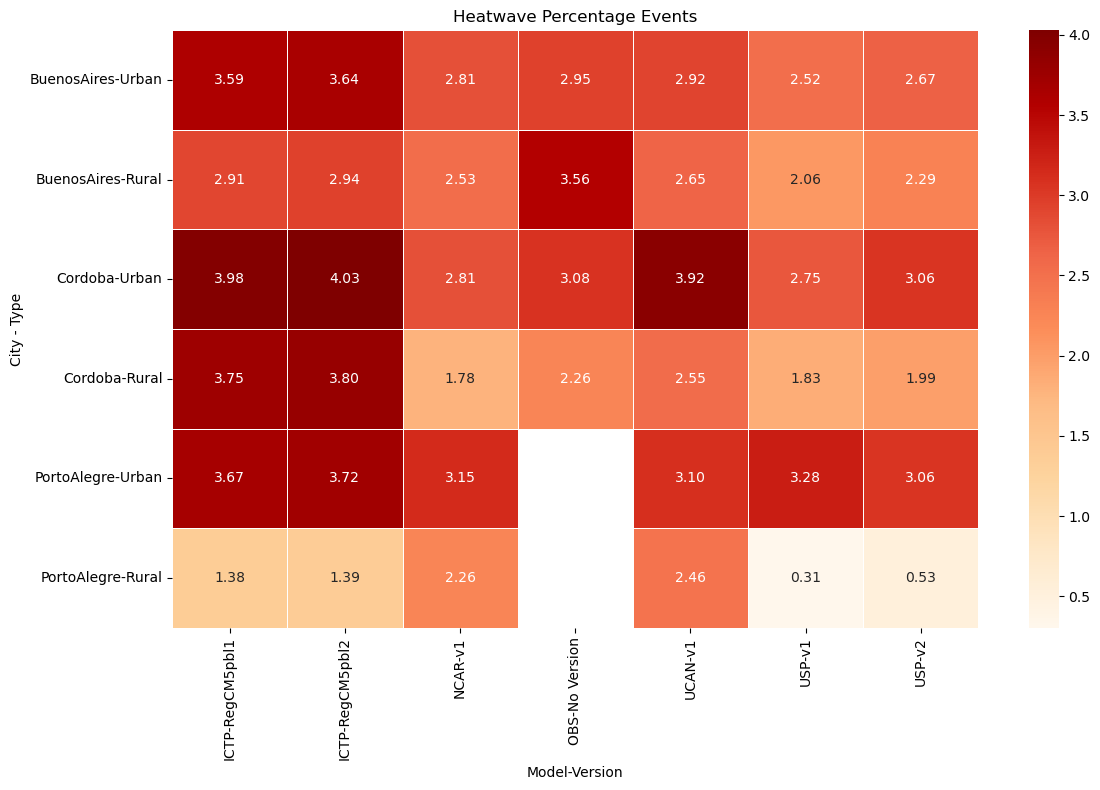

In [19]:
# Load urban and rural data
urban_df = pd.read_csv('results/heatwave_urban_number.csv')
rural_df = pd.read_csv('results/heatwave_rural_number.csv')

# Add resolution days to both datasets
urban_df = add_resolution_days(urban_df)
rural_df = add_resolution_days(rural_df)

# Add a column to distinguish between urban and rural data
urban_df['type'] = 'Urban'
rural_df['type'] = 'Rural'

# Concatenate both datasets into one combined dataframe
combined_df = pd.concat([urban_df, rural_df])

# Calculate the percentage of heatwave days
combined_df['percentage_days'] = combined_df['event_count'] / combined_df['resolution_days'] * 100

# Create a new column combining model and version
combined_df['model_version'] = combined_df['model'] + '-' + combined_df['version'].fillna('No Version')

# Pivot the data to make it suitable for a heatmap
pivot_df = combined_df.pivot_table(
    index=['city', 'type'],  # Rows will be city and type (urban/rural)
    columns='model_version',  # Columns will be the model-version combination
    values='percentage_days'  # Values will be the percentage of heatwave days
)

# Reorder rows so urban and rural are next to each other
pivot_df = pivot_df.reindex(
    [(city, t) for city in combined_df['city'].unique() for t in ['Urban', 'Rural']]
)

# Plot the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(pivot_df, annot=True, fmt=".2f", cmap='OrRd', linewidths=0.5)
plt.title('Heatwave Percentage Events')
plt.xlabel('Model-Version')  # Label for the x-axis
plt.ylabel('City - Type')  # Label for the y-axis
plt.tight_layout()

plt.savefig("results/heatwave_events.pdf", format='pdf')
plt.show()


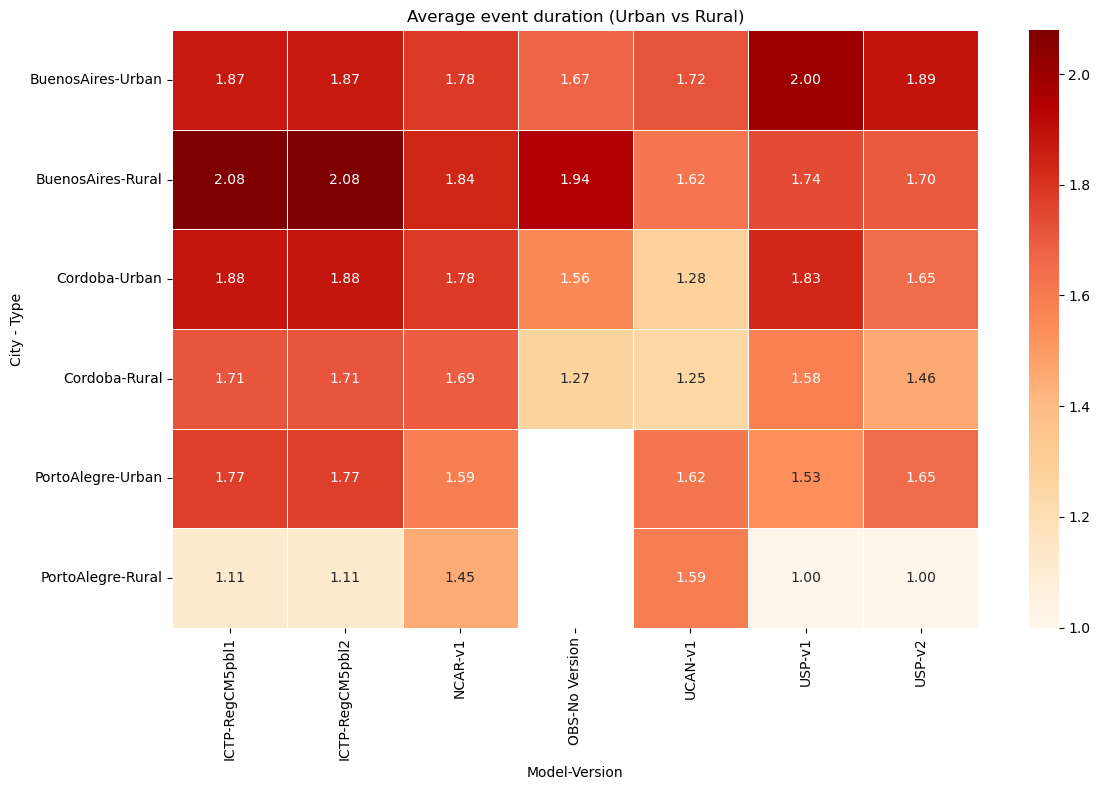

In [20]:
# Load urban and rural data
urban_df = pd.read_csv('results/heatwave_urban_number.csv')
rural_df = pd.read_csv('results/heatwave_rural_number.csv')

# Add resolution days to both datasets
urban_df = add_resolution_days(urban_df)
rural_df = add_resolution_days(rural_df)

# Add a column to distinguish between urban and rural data
urban_df['type'] = 'Urban'
rural_df['type'] = 'Rural'

# Concatenate both datasets into one combined dataframe
combined_df = pd.concat([urban_df, rural_df])



# Create a new column combining model and version
combined_df['model_version'] = combined_df['model'] + '-' + combined_df['version'].fillna('No Version')

# Pivot the data to make it suitable for a heatmap
pivot_df = combined_df.pivot_table(
    index=['city', 'type'],  # Rows will be city and type (urban/rural)
    columns='model_version',  # Columns will be the model-version combination
    values='average_streak_length'  # Values will be the percentage of heatwave days
)

# Reorder rows so urban and rural are next to each other
pivot_df = pivot_df.reindex(
    [(city, t) for city in combined_df['city'].unique() for t in ['Urban', 'Rural']]
)

# Plot the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(pivot_df, annot=True, fmt=".2f", cmap='OrRd', linewidths=0.5)
plt.title('Average event duration (Urban vs Rural)')
plt.xlabel('Model-Version')  # Label for the x-axis
plt.ylabel('City - Type')  # Label for the y-axis
plt.tight_layout()

plt.savefig("results/heatwave_duration.pdf", format='pdf')
plt.show()
